## Day3 Kisckstarter Project

## Day2からの変更

- 使用する説明変数を吟味<br>
- 決定木、ランダムフォレスト、NN、これらを利用したアンサンブル学習を検討

In [1]:
#ライブラリインポート
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.linear_model import LinearRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
import tensorflow as tf
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

from IPython.display import display
from datetime import datetime as dt
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import os

pd.set_option('display.max_columns', 50)

In [2]:
#関数定義
def object2time(time):
    return dt.strptime(time, '%Y-%m-%d')

def object2timeHMS(time):
    return dt.strptime(time, '%Y-%m-%d %H:%M:%S')


In [3]:
# グラフ表示用メソッド定義from稲田さん
def plot_graph(df, item_name):
    fig,ax = plt.subplots(1,2, figsize=(20,6))

    # 項目のグラフ表示
    sns_ax = ax[0]
    sns_item=sns.countplot(df[item_name],order=np.sort(df[item_name].unique()), ax=sns_ax)
    sns_item.set_xticklabels(sns_item.get_xticklabels(), rotation=90, ha="right")  # 90度回転
    
    #　項目の成否の割合
    cross_ax = ax[1]
    cross_item = pd.crosstab(df[item_name],df['state'],normalize='index')
    cross_item.plot.bar(stacked=True, ax=cross_ax)

    plt.tight_layout()
    plt.show()

In [4]:
#評価出力用の関数定義
def evaluation(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    y_est = clf.predict(X_test)
    y_est_train = clf.predict(X_train)
    evaluation_score = []
    evaluation_score_train = []
    evaluation_score_test = []
    precision, recall, f1_score, cl_repot = precision_recall_fscore_support(y_test, y_est)
    evaluation_score_test.append(log_loss(y_test,y_est))
    evaluation_score_test.append(accuracy_score(y_test,y_est)*100)
    evaluation_score_test.append(precision[1]*100)
    evaluation_score_test.append(recall[1]*100)
    evaluation_score_test.append(f1_score[1]*100)
    
    precision, recall, f1_score, cl_repot = precision_recall_fscore_support(y_train, y_est_train)
    evaluation_score_train.append(log_loss(y_train,y_est_train))
    evaluation_score_train.append(accuracy_score(y_train,y_est_train)*100)
    evaluation_score_train.append(precision[1]*100)
    evaluation_score_train.append(recall[1]*100)
    evaluation_score_train.append(f1_score[1]*100)
    
    evaluation_score = np.stack([evaluation_score_train, evaluation_score_test],0)
    df = pd.DataFrame(evaluation_score,index =["train","test"],columns=["対数尤度","正答率","Precision","Recall","F1値"])
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                            index=['正解 = failed(success以外)', '正解 = success'], 
                            columns=['予測 = failed(success以外)', '予測 = success'])
    return conf_mat, df

In [102]:
def evaluation_data(y_train_pred, y_test_pred, y_train, y_test):
    evaluation_score = []
    evaluation_score_train = []
    evaluation_score_test = []
    precision, recall, f1_score, cl_repot = precision_recall_fscore_support(y_test, y_test_pred)
    evaluation_score_test.append(log_loss(y_test, y_test_pred))
    evaluation_score_test.append(accuracy_score(y_test, y_test_pred)*100)
    evaluation_score_test.append(precision[1]*100)
    evaluation_score_test.append(recall[1]*100)
    evaluation_score_test.append(f1_score[1]*100)

    precision, recall, f1_score, cl_repot = precision_recall_fscore_support(y_train, y_train_pred)
    evaluation_score_train.append(log_loss(y_train, y_train_pred))
    evaluation_score_train.append(accuracy_score(y_train, y_train_pred)*100)
    evaluation_score_train.append(precision[1]*100)
    evaluation_score_train.append(recall[1]*100)
    evaluation_score_train.append(f1_score[1]*100)

    evaluation_score = np.stack([evaluation_score_train, evaluation_score_test],0)
    df = pd.DataFrame(evaluation_score,index =["train","test"],columns=["対数尤度","正答率","Precision","Recall","F1値"])
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                            index=['正解 = failed(success以外)', '正解 = success'], 
                            columns=['予測 = failed(success以外)', '予測 = success'])
    return conf_mat, df

In [5]:
#データの読み込み

origin_data = pd.read_csv("./ks-projects-201801.csv",sep = ",")
origin_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


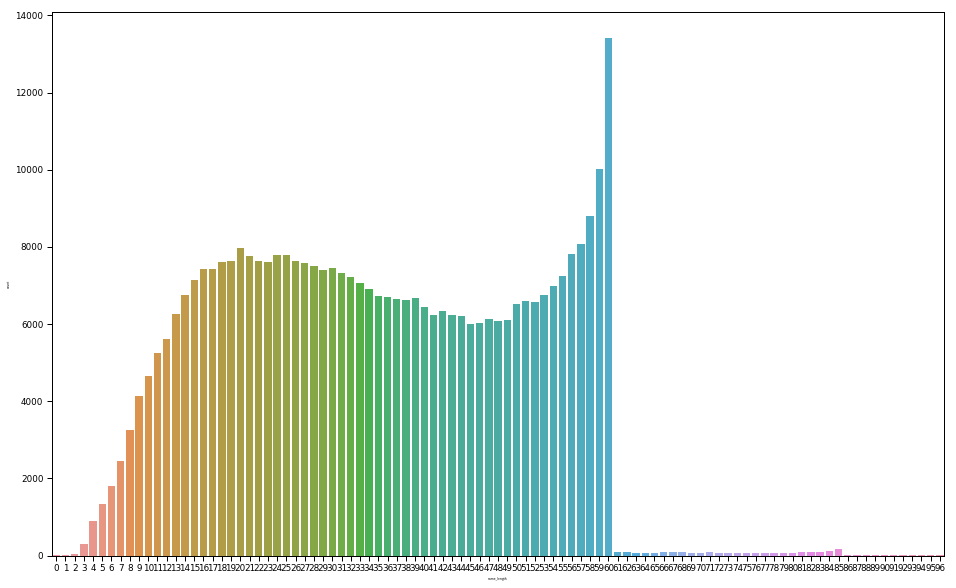

In [30]:
origin_data["name_length"] = origin_data["name"].str.len().fillna(0.0).astype(int)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   
plt.figure(figsize=(16,10))
sns.countplot(origin_data["name_length"])

# 方針/雑感
- state → 予測対象、まずはsuccessとその他に1/0で分ける
- ID → 不要と判断
- name → 不要と判断、欠損は無視
- name_lengh → 追加
- category → ユニーク数が多いので保留
- main_category → ユニーク数がそこまで多くないのでワンホットエンコーディングかカテゴリごとにIDを振る
- currency  → ユニーク数がそこまで多くないのでワンホットエンコーディングかカテゴリごとにIDを振る
- deadline  → データ数の割にユニーク数が少ない、同じ値で比較するとで何か見えるかも
- goal → 同上→結果となるパラメータの為不採用
- launched → deadlineとの差分で期間が出るのでそちらを使う
- pledged → 現在の支援額、大きく影響すると思われる→結果となるパラメータの為不採用
- backers → データ数の割にユニーク数が少ない、Stateとの比較を実施→結果となるパラメータの為不採用
- country → データ数の割にユニーク数が少ない、同じ値で比較すると何か見えるかも、N,0"はNull?現状保留
- usd pledged → 欠損は0で埋める、Stateとの対比は実施→結果となるパラメータの為不採用
- usd_pledged_real → とりあえず予測に入れてみる→結果となるパラメータの為不採用
- usd_goal_real → とりあえず予測に入れてみる→予測対象として採用

In [19]:
#データコピー
df = origin_data.copy()


#stateの0/1変換
df.loc[df["state"] == "successful", "state"] = 1
df.loc[df["state"] != 1, "state"] = 0

#不要なcolumnの削除
df.drop("ID", axis=1, inplace=True)
df.drop("name", axis=1, inplace=True)
df.drop("category", axis=1, inplace=True)
df.drop("goal", axis=1, inplace=True)
df.drop("pledged", axis=1, inplace=True)
df.drop("usd pledged", axis=1, inplace=True)
df.drop("usd_pledged_real", axis=1, inplace=True)
df.drop("backers", axis=1, inplace=True)
df.drop("currency", axis=1, inplace=True)#countryと相関があるため削除
# df.drop("country", axis=1, inplace=True)#currencyと相関があるため削除

#usd_goal_realの対数化
df["usd_goal_real_log10"] = np.log10(df["usd_goal_real"])
# df["usd_goal_real"] = np.log10(df["usd_goal_real"])

#日付の型変更,priod(期間)の追加
df["deadline"] = df["deadline"].apply(object2time)
df["launched"] = df["launched"].apply(object2timeHMS)
df["period"] =  df["deadline"] - df["launched"]
df["period"] = df["period"].dt.days

df.drop("deadline", axis=1, inplace=True)
df.drop("launched", axis=1, inplace=True)


#ユニーク数が少ない項目をワンホットエンコーディング
df = pd.get_dummies(df,columns=["main_category"])
# df = pd.get_dummies(df,columns=["currency"])
df = pd.get_dummies(df,columns=["country"])

df.head()



,state,usd_goal_real,usd_goal_real_log10,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,1533.95,3.185811,58,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,30000.00,4.477121,59,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,4.653213,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,3.698970,29,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,19500.00,4.290035,55,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


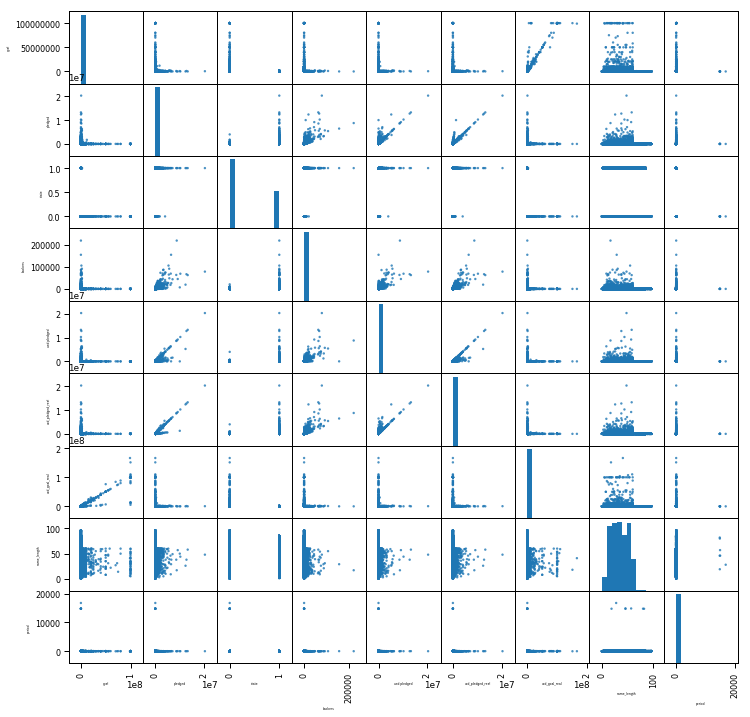

In [32]:
# 散布図
pd.plotting.scatter_matrix(df,alpha = 0.8, figsize=(12,12),range_padding = 0.5)
plt.show()

In [36]:
df.describe()

,state,usd_goal_real,name_length,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.00000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000
mean,0.353762,3.750108,34.834847,33.481122,0.074349,0.028572,0.023264,0.009951,0.079411,0.060254,0.167921,0.064971,0.093041,0.012557,0.137109,0.028466,0.105303,0.086011,0.02882,0.020995,0.039513,0.002028,0.002982,0.045965,0.090139,0.001632,0.000106,0.004627,0.001907,0.003895,0.004722,0.001466,0.780025
std,0.478137,0.737391,15.931822,65.909172,0.262338,0.166600,0.150740,0.099257,0.270380,0.237958,0.373796,0.246475,0.290490,0.111354,0.343963,0.166300,0.306943,0.280381,0.16730,0.143368,0.194812,0.044990,0.054522,0.209409,0.286381,0.040366,0.010277,0.067863,0.043624,0.062291,0.068554,0.038256,0.414230
min,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.301030,21.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.740363,34.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,4.190332,49.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,8.221053,96.000000,16738.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
# 相関係数
df.corr()

,state,usd_goal_real,name_length,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
state,1.000000,-0.222357,0.065448,-0.026096,0.032645,0.066792,-0.036689,0.055926,-0.001790,-0.057528,0.016683,-0.058673,0.001038,-0.033240,0.093623,-0.016879,-0.032497,-0.100224,0.088260,-0.030875,-0.032775,-0.010397,-0.003789,-0.060011,0.000123,-0.000359,-0.003843,-0.018214,-0.011701,-0.006544,-0.009952,-0.002648,0.065202
usd_goal_real,-0.222357,1.000000,0.054150,0.034061,-0.126806,-0.057638,-0.085789,-0.029426,0.092535,-0.008377,0.057074,0.055418,0.045223,-0.010971,-0.095812,-0.045572,-0.057763,0.195088,-0.045715,0.000076,-0.007136,0.024890,-0.006229,0.048418,-0.034747,0.007315,0.001513,-0.024345,-0.001277,-0.005583,-0.001450,-0.004275,0.005838
name_length,0.065448,0.054150,1.000000,0.008375,-0.004579,-0.020385,-0.016061,0.007638,0.081607,0.011613,-0.120249,-0.011909,-0.044667,-0.005970,0.041230,-0.003991,0.034615,0.053830,0.022240,-0.000468,-0.009215,0.002258,-0.007089,-0.003268,-0.017660,0.018607,0.002510,-0.015839,-0.008191,-0.000515,-0.007865,0.010099,0.021073
period,-0.026096,0.034061,0.008375,1.000000,-0.005782,-0.000844,-0.006770,-0.002098,0.002233,-0.006241,0.008640,-0.001610,-0.009367,0.000162,0.007358,-0.001627,-0.000369,0.004566,0.001258,-0.002087,-0.000654,0.015683,-0.001044,0.001552,-0.011503,-0.000047,-0.000442,0.002560,0.000266,-0.002500,-0.001081,-0.001180,0.006864
main_category_Art,0.032645,-0.126806,-0.004579,-0.005782,1.000000,-0.048604,-0.043738,-0.028413,-0.083238,-0.071763,-0.127316,-0.074707,-0.090773,-0.031960,-0.112972,-0.048512,-0.097229,-0.086940,-0.048821,-0.011661,-0.002346,-0.002036,0.000934,-0.010145,0.004546,-0.002980,-0.000954,0.004412,-0.004541,-0.003016,-0.003074,-0.002964,0.008529
main_category_Comics,0.066792,-0.057638,-0.020385,-0.000844,-0.048604,1.000000,-0.026467,-0.017194,-0.050370,-0.043426,-0.077043,-0.045207,-0.054930,-0.019340,-0.068363,-0.029356,-0.058836,-0.052610,-0.029543,-0.004328,0.007609,-0.005617,-0.005017,-0.022201,-0.005990,-0.003792,-0.001763,-0.003517,-0.001319,-0.006653,-0.006032,-0.003670,0.018021
main_category_Crafts,-0.036689,-0.085789,-0.016061,-0.006770,-0.043738,-0.026467,1.000000,-0.015472,-0.045327,-0.039079,-0.069330,-0.040681,-0.049430,-0.017404,-0.061518,-0.026417,-0.052946,-0.047343,-0.026586,-0.000238,0.007008,0.001610,0.002164,-0.001163,0.006727,-0.001032,-0.001586,0.005742,0.000082,0.002443,-0.001174,0.007826,-0.009442
main_category_Dance,0.055926,-0.029426,0.007638,-0.002098,-0.028413,-0.017194,-0.015472,1.000000,-0.029445,-0.025386,-0.045037,-0.026427,-0.032110,-0.011306,-0.039963,-0.017161,-0.034394,-0.030754,-0.017270,-0.008743,-0.007496,-0.002154,-0.004018,-0.012095,-0.005541,-0.003394,-0.001030,0.002574,-0.000113,-0.002852,-0.004189,-0.003145,0.018619
main_category_Design,-0.001790,0.092535,0.081607,0.002233,-0.083238,-0.050370,-0.045327,-0.029445,1.000000,-0.074370,-0.131941,-0.077421,-0.094070,-0.033121,-0.117075,-0.050274,-0.100760,-0.090098,-0.050595,0.020280,0.015635,0.015417,0.015289,0.031336,-0.000152,0.045230,0.004584,-0.004480,0.001044,0.006251,0.004276,0.024491,-0.041602
main_category_Fashion,-0.057528,-0.008377,0.011613,-0.006241,-0.071763,-0.043426,-0.039079,-0.025386,-0.074370,1.000000,-0.113752,-0.066748,-0.081102,-0.028555,-0.100936,-0.043344,-0.086870,-0.077678,-0.043620,0.018422,0.009028,0.004619,0.001826,0.020471,0.012223,0.002134,0.006036,-0.004835,-0.000637,0.002160,0.003281,0.020469,-0.032420


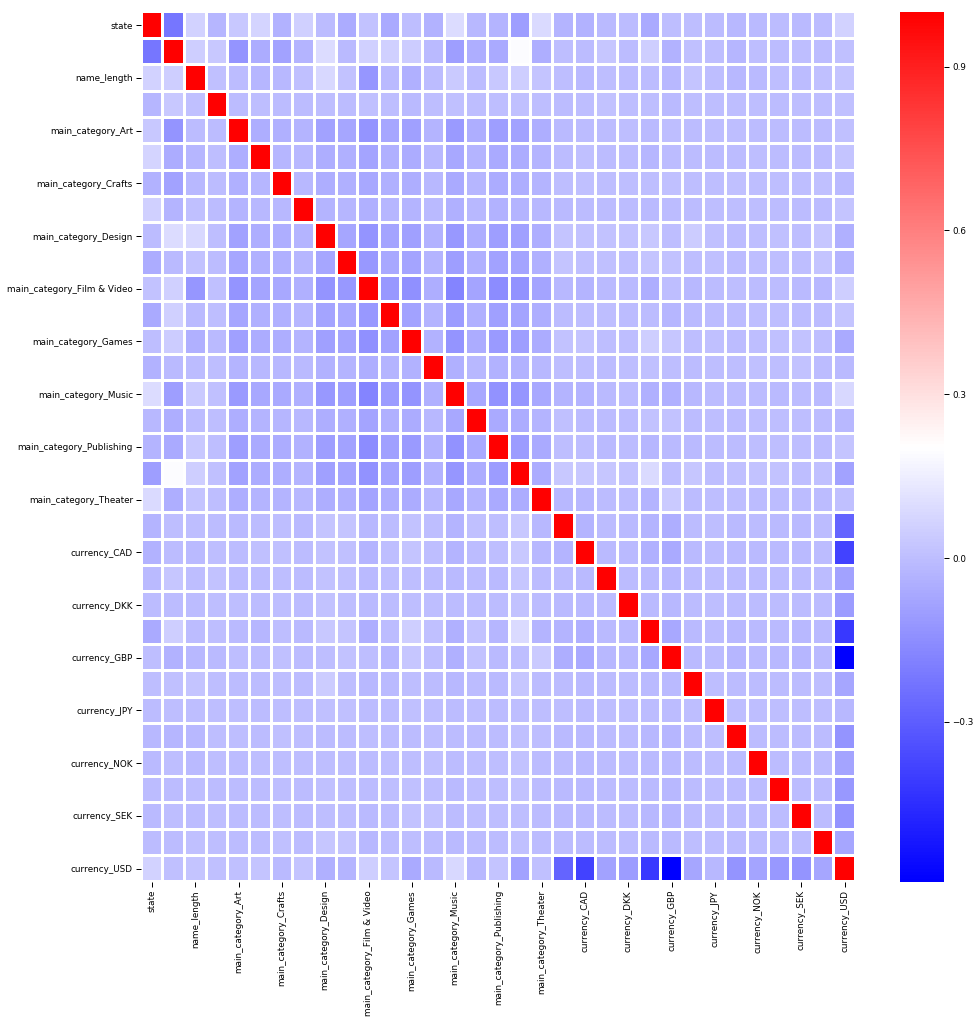

In [38]:
#ヒートマップ
# sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2) 
sns.heatmap(df.corr(),cmap='bwr',linewidths=2) 
fig=plt.gcf()
fig.set_size_inches(16,16)
plt.show()

## day1時点の検証
- 標準化、パラメータ探索を実施しないSGDClassifier
- 説明変数も増加させない(name_length, usd_goal_realも対数化しない)

In [9]:
df_day1 = df.copy()
df_day1.drop("usd_goal_real_log10", axis=1, inplace=True)
print(df_day1.columns)
y = df["state"].values
X = df.drop('state', axis=1).values

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=10, tol=1e-3)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
day1_conf, day1_evaluation_score = evaluation(X_train, X_test, y_train, y_test, clf)
day1_evaluation_score

Index(['state', 'usd_goal_real', 'period', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtype='object')


,対数尤度,正答率,Precision,Recall,F1値
train,16.509221,52.201843,40.945015,78.986264,53.932448
test,16.464994,52.329896,40.859508,79.272045,53.924497


正答率、Precision等について、train時のデータが特別良いという訳ではなく、未学習の領域にあると判断する

## day2時点の検証
- 正規化の導入
- グリッドサーチによるハイパーパラメータの探索

In [145]:
stdsc = StandardScaler()
df_day2 = df.copy()
df_day2.drop("usd_goal_real", axis=1, inplace=True)
print(df_day2.columns)
y = df_day2["state"].values
X = df_day2.drop('state', axis=1).values

# X_std = stdsc.fit_transform(df_day2.values)
# df_day2_std = pd.DataFrame(X_std,columns=df_day2.columns)
# df_day2_std.head()

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

parameters = {
                "loss":["log","hinge"],
                "penalty":["none","l1","l2","elasticnet"],
                "max_iter":[5000,10000],
                "alpha":[1e-5, 1e-2,1e-1,1,10],
                "random_state":[1234],
                "tol":[1e-3]
                }

sgdcl = SGDClassifier(fit_intercept=True)
grid_search = GridSearchCV(sgdcl,parameters,cv=5)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_, grid_search.best_score_)


Index(['state', 'name_length', 'usd_goal_real_log10', 'period',
       'main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'currency_AUD', 'currency_CAD', 'currency_CHF',
       'currency_DKK', 'currency_EUR', 'currency_GBP', 'currency_HKD',
       'currency_JPY', 'currency_MXN', 'currency_NOK', 'currency_NZD',
       'currency_SEK', 'currency_SGD', 'currency_USD'],
      dtype='object')
{'alpha': 0.01, 'loss': 'log', 'max_iter': 5000, 'penalty': 'none', 'random_state': 1234, 'tol': 0.001} 0.6733778323562034


In [146]:
clf = SGDClassifier(**grid_search.best_params_,fit_intercept=True)
clf.fit(X_test,y_test)
day2_conf, day2_evaluation_score = evaluation(X_train, X_test, y_train, y_test, clf)
day2_evaluation_score

,対数尤度,正答率,Precision,Recall,F1値
train,11.314486,67.241391,57.253267,29.685199,39.098335
test,11.293475,67.302233,56.526250,30.664165,39.759652


day1時点の予測結果と比べると正答率、Precisionは約15%、対数尤度は5向上している<br>
一方Recallは約54%程下がった

### SVMの検討
- 学習に利用するデータは1%とした(GridSearchCVで5時間ぐらい掛かった)

In [100]:
#SGDClassifierで予測

df_day2 = df.copy()
df_day2.drop("usd_goal_real", axis=1, inplace=True)

y = df_day2["state"].values
X = df_day2.drop('state', axis=1).values

#ホールドアウト
#計算時間を考慮して1%のデータで計算
test_size = 0.99
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

parameters = {
    'kernel':['linear'],
    'C':[10,50,100],
    "gamma":[0.1,1,10]} 

model = SVC()
clf = GridSearchCV(model, parameters, cv=5,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 10, 'gamma': 0.1, 'kernel': 'linear'} 0.6568938193343898


In [102]:
svm = SVC(**clf.best_params_)
day2_svm_conf, day2_svm_evaluation_score = evaluation(X_train, X_test, y_train, y_test, svm)
day2_svm_evaluation_score

,対数尤度,正答率,Precision,Recall,F1値
train,11.777505,65.900687,56.459330,8.952959,15.455141
test,11.981694,65.309503,55.730963,9.501802,16.235540


SVMでの計算は計算時間が非常に長く掛かるため、ごく一部のデータを使用した学習しかできなかった<br>
正答率は65%程でSGDClassifierと比較すると2%程低下した、一方Recallは20%程下がった<br>
データ量1%で近い水準の結果が出せることが分かった<br>
GridSearchCVで求めたパラメータを利用して、もう少しデータ量を増やすとさらに精度は上がるかもしれないが、今回はここで止める

## Day3ここから

### 特徴量の検討
- Day2まではCurrencyとCountryに相関があるため、Currencyだけ残して計算を実施している(ワッパー法)

Countryを残し、Currencyを消した場合を計算し、Day2の結果と比較(ワッパー法)

In [67]:

df_day3 = df.copy()
df_day3.drop("usd_goal_real", axis=1, inplace=True)
print(df_day3.columns)
y = df_day3["state"].values
X = df_day3.drop('state', axis=1).values

# X_std = stdsc.fit_transform(df_day2.values)
# df_day2_std = pd.DataFrame(X_std,columns=df_day2.columns)
# df_day2_std.head()

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

parameters = {
                "loss":["log","hinge"],
                "penalty":["none","l1","l2","elasticnet"],
                "max_iter":[5000,10000],
                "alpha":[1e-5, 1e-2, 1e-1,1,10],
                "random_state":[1234],
                "tol":[1e-3]
                }

sgdcl = SGDClassifier(fit_intercept=True)
grid_search = GridSearchCV(sgdcl,parameters,cv=5)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_, grid_search.best_score_)

sgd = SGDClassifier(**grid_search.best_params_,fit_intercept=True)
sgd.fit(X_test,y_test)
day3_conf, day3_evaluation_score = evaluation(X_train, X_test, y_train, y_test, sgd)
day3_evaluation_score

Index(['state', 'usd_goal_real_log10', 'period', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtype='object')
{'alpha': 0.01, 'loss': 'log', 'max_iter': 5000, 'penalty': 'none', 'random_state': 1234, 'tol': 0.001} 0.6743252522051445


,対数尤度,正答率,Precision,Recall,F1値
train,11.245392,67.441438,57.65397,30.454961,39.856332
test,11.225979,67.497656,56.90814,31.452158,40.513304


ほぼすべての評価指数でCountryを残した方がスコアが良い<br>
→Countryを特徴量として採用

In [125]:
df_day3
y = df_day3["state"]
X = df_day3.drop('state', axis=1)

estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)
# sfm.fit(X_train, y_train)
sfm.fit(X.values, y.values)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [126]:
#X_trainとX、どちらで実施しても結果は同じ
sfm.get_support()

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True])

In [139]:
removed_idx  = sfm.get_support()
# 取り除くcolumnの表示
X.columns[~removed_idx]

Index(['main_category_Art', 'country_SE'], dtype='object')

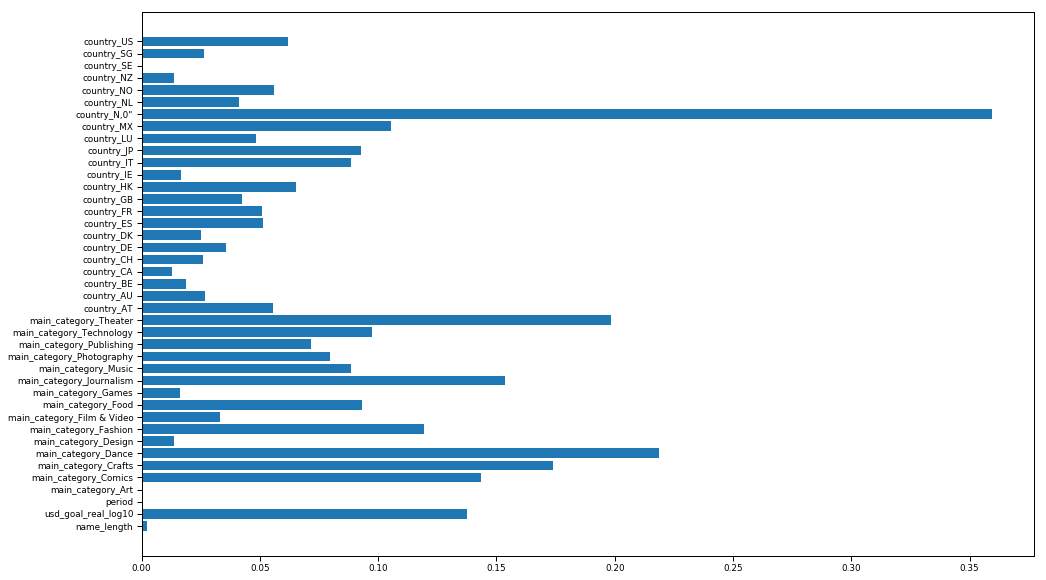

In [128]:
abs_coef = np.abs(sfm.estimator_.coef_)
plt.figure(figsize=(16,10))
plt.barh(np.arange(0, len(abs_coef)) , abs_coef, tick_label=X.columns.values)
plt.show()

意外にもperiodが全然効いていない
country_SE, main_category_Artを除いて再計算

In [70]:

df_day3 = df.copy()
df_day3.drop("usd_goal_real", axis=1, inplace=True)
df_day3.drop("main_category_Art", axis=1, inplace=True)
df_day3.drop("country_SE", axis=1, inplace=True)

print(df_day3.columns)
y = df_day3["state"].values
X = df_day3.drop('state', axis=1).values

# X_std = stdsc.fit_transform(df_day2.values)
# df_day2_std = pd.DataFrame(X_std,columns=df_day2.columns)
# df_day2_std.head()

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

parameters = {
                "loss":["log","hinge"],
                "penalty":["none","l1","l2","elasticnet"],
                "max_iter":[5000,10000],
                "alpha":[1e-5, 1e-2, 1e-1,1,10],
                "random_state":[1234],
                "tol":[1e-3]
                }

sgdcl = SGDClassifier(fit_intercept=True)
grid_search = GridSearchCV(sgdcl,parameters,cv=5)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_, grid_search.best_score_)

sgd = SGDClassifier(**grid_search.best_params_,fit_intercept=True)
day3_conf, day3_evaluation_score = evaluation(X_train, X_test, y_train, y_test, sgd)
day3_evaluation_score

Index(['state', 'usd_goal_real_log10', 'period', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SG', 'country_US'],
      dtype='object')
{'alpha': 0.01, 'loss': 'log', 'max_iter': 5000, 'penalty': 'none', 'random_state': 1234, 'tol': 0.001} 0.6749953784397613


,対数尤度,正答率,Precision,Recall,F1値
train,11.239008,67.459924,57.62002,30.769948,40.116883
test,11.205912,67.555755,57.01938,31.684803,40.734219


特徴量を減らすことで、わずかではあるが汎化誤差が改善

決定木の検討

In [7]:
stdsc = StandardScaler()
df_day3 = df.copy()
df_day3.drop("usd_goal_real", axis=1, inplace=True)
df_day3.drop("main_category_Art", axis=1, inplace=True)
df_day3.drop("country_SE", axis=1, inplace=True)

print(df_day3.columns)
y = df_day3["state"].values
X = df_day3.drop('state', axis=1).values

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

clf = DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=3, random_state=1234)
day3_DecisionTree_conf, day3_DecisionTree_evaluation_score = evaluation(X_train, X_test, y_train, y_test, clf)
day3_DecisionTree_evaluation_score

Index(['state', 'usd_goal_real_log10', 'period', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SG', 'country_US'],
      dtype='object')


,対数尤度,正答率,Precision,Recall,F1値
train,11.593822,66.432618,55.614375,25.944495,35.382709
test,12.714632,63.187778,47.593876,45.609756,46.580697


In [13]:
day3_DecisionTree_conf

,予測 = failed(success以外),予測 = success
正解 = failed(success以外),35699,13384
正解 = success,14495,12155


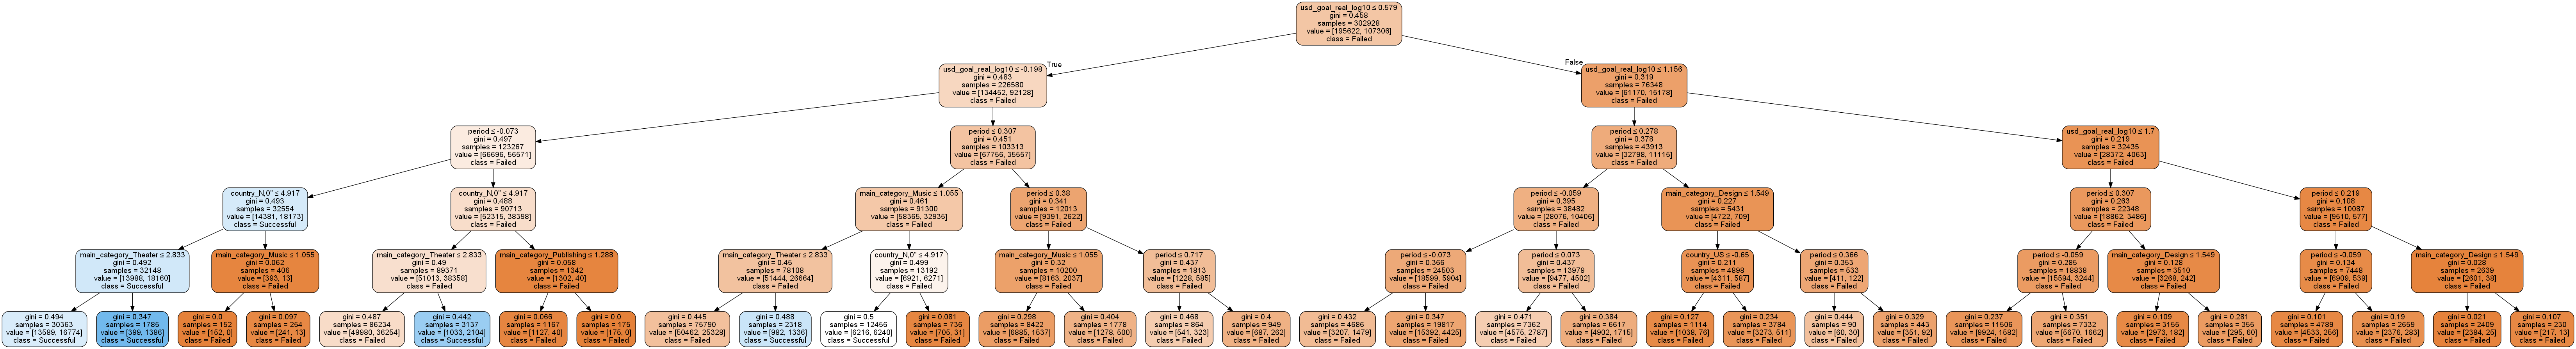

In [8]:
# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=df_day3.drop('state', axis=1).columns,
                     class_names=["Failed","Successful"],
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

RandomForestの検討

In [9]:
df_day3 = df.copy()
df_day3.drop("usd_goal_real", axis=1, inplace=True)
df_day3.drop("main_category_Art", axis=1, inplace=True)
df_day3.drop("country_SE", axis=1, inplace=True)

print(df_day3.columns)
y = df_day3["state"].values
X = df_day3.drop('state', axis=1).values

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

rfc = RandomForestClassifier(n_estimators=1000, max_depth=5, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)


day3_RandomForest_conf, day3_RandomForest_evaluation_score = evaluation(X_train, X_test, y_train, y_test, rfc)
day3_RandomForest_evaluation_score

Index(['state', 'usd_goal_real_log10', 'period', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SG', 'country_US'],
      dtype='object')


,対数尤度,正答率,Precision,Recall,F1値
train,11.891694,65.570036,69.867900,4.928895,9.20819
test,11.578466,66.476965,62.732042,11.666041,19.67348


[3.89773928e-01 1.89861867e-01 2.71308874e-02 5.98869302e-03
 1.50653590e-02 1.00157787e-03 2.30865487e-02 1.47998942e-03
 1.89788262e-02 8.29022044e-04 3.29350729e-03 7.24002399e-02
 7.00830950e-04 5.41202434e-03 8.03823657e-02 6.52282307e-02
 7.40988143e-05 1.66517548e-03 6.32511215e-05 1.55047109e-03
 3.89503237e-05 1.04500481e-03 7.56896836e-05 5.47558863e-04
 1.22156053e-04 4.57192479e-03 1.23797630e-04 6.29616288e-05
 3.92597713e-03 8.32084273e-06 9.25819004e-06 4.69554609e-04
 4.63695322e-02 5.67564809e-04 7.45269894e-05 6.16779317e-05
 4.00453327e-05 3.79186034e-02]


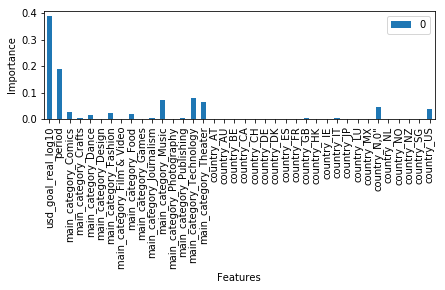

In [12]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_day3.drop('state', axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

過学習気味
GridSearchCVを用いてパラメータを探索する

In [27]:
df_day3 = df.copy()
df_day3.drop("usd_goal_real", axis=1, inplace=True)
df_day3.drop("main_category_Art", axis=1, inplace=True)
df_day3.drop("country_SE", axis=1, inplace=True)

print(df_day3.columns)
y = df_day3["state"].values
X = df_day3.drop('state', axis=1).values

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

parameters = {
                'n_estimators':[10,50,100,200],
                'max_depth':[10,20,100],
                "min_samples_leaf":[2,4,6],
                "min_samples_split":[2,4,6],
            } 


model = RandomForestClassifier(criterion="gini",random_state=1234)
grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_, grid_search.best_score_)

rfc = RandomForestClassifier(**grid_search.best_params_,criterion="gini",random_state=1234)

day3_RandomForest_conf, day3_RandomForest_evaluation_score = evaluation(X_train, X_test, y_train, y_test, rfc)
day3_RandomForest_evaluation_score

Index(['state', 'usd_goal_real_log10', 'period', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SG', 'country_US'],
      dtype='object')
{'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200} 0.6872821264458882


,対数尤度,正答率,Precision,Recall,F1値
train,10.264503,70.281387,64.171833,36.459285,46.499715
test,11.465002,66.805752,53.242072,46.555347,49.674694


[4.35178133e-01 2.40928409e-01 2.33057368e-02 1.27744144e-02
 1.39621675e-02 5.73976058e-03 2.24338617e-02 7.54746982e-03
 1.43238997e-02 5.77092244e-03 7.08018649e-03 4.07352079e-02
 5.49008009e-03 1.14856265e-02 3.64532339e-02 3.89584534e-02
 2.53726561e-04 1.97530711e-03 2.10673056e-04 2.79399878e-03
 2.42147469e-04 1.50116531e-03 4.91493053e-04 9.52575756e-04
 1.14165639e-03 7.03945643e-03 5.02591216e-04 3.00522091e-04
 2.92027909e-03 1.48192772e-06 7.57987170e-06 1.46609570e-03
 3.01876727e-02 1.44511974e-03 2.97054027e-04 5.58717990e-04
 2.97136349e-04 2.32459861e-02]


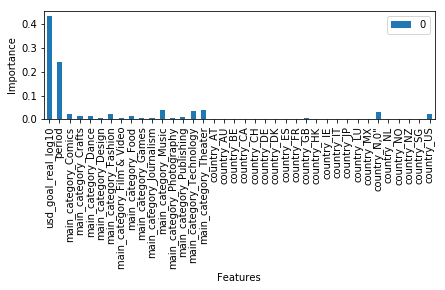

In [28]:
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_day3.drop('state', axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

TrainAccuracyは向上したが、TestAccuracyは変化しなかった

### NNの検討
- ライブラリはkerasを使用
- 2値分類の為lossはbinary_crossentropy、出力層の活性化関数はsigmoidを使用

In [128]:
df_day3 = df.copy()
df_day3.drop("usd_goal_real", axis=1, inplace=True)
df_day3.drop("main_category_Art", axis=1, inplace=True)
df_day3.drop("country_SE", axis=1, inplace=True)

print(df_day3.columns)
y = df_day3["state"].values
X = df_day3.drop('state', axis=1).values

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=1234)

X_train = stdsc.fit_transform(X_train)
X_valid = stdsc.fit_transform(X_valid)
X_test = stdsc.fit_transform(X_test)

mln = Sequential()
mln.add(Dense(100, activation='relu', input_dim=X.shape[1]))
mln.add(Dense(50, activation='relu', input_dim=100))
mln.add(Dense(25, activation='relu', input_dim=50))
mln.add(Dense(10, activation='relu', input_dim=25))
# mln.add(Dense(1, activation='softmax'))
mln.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
rms = RMSprop(lr=0.01)
adag = Adagrad(lr=0.01)
adad = Adadelta(lr=0.01)
adam = Adam(lr=0.001)


mln.compile(optimizer=adam,
            loss='binary_crossentropy',
            metrics=['acc'])


mln_fit = mln.fit(X_train, y_train,
          epochs=30,
          batch_size=30,validation_data=(X_valid, y_valid))

df3_NN = pd.DataFrame(mln_fit.history)




Index(['state', 'usd_goal_real_log10', 'period', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SG', 'country_US'],
      dtype='object')
Train on 242342 samples, validate on 60586 samples
Epoch 1/30
242342/242342 [==============================] - 20s 84us/sample - loss: 0.5955 - acc: 0.6754 - val_loss: 0.6511 - val_acc: 0.6540

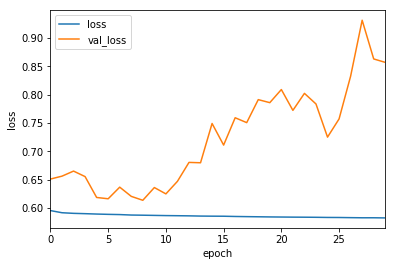

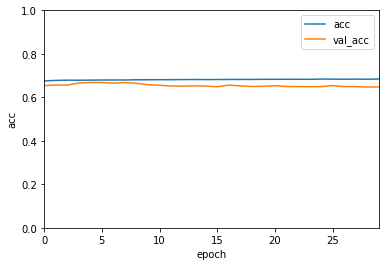

In [129]:
df3_NN[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df3_NN[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

validation_lossは振動しているが、その他の値はepochを増やしてもほぼ変化していない<br>
→未学習、特徴量を増やす、高次の特徴を追加する等の対策が考えられる<br>
→epoch5時点の重みを使用する

In [130]:
mln_fit = mln.fit(X_train, y_train,
          epochs=5,
          batch_size=30,validation_data=(X_valid, y_valid))

df3_NN = pd.DataFrame(mln_fit.history)

Train on 242342 samples, validate on 60586 samples
Epoch 1/5
242342/242342 [==============================] - 21s 85us/sample - loss: 0.5825 - acc: 0.6841 - val_loss: 0.9515 - val_acc: 0.6509
Epoch 2/5
242342/242342 [==============================] - 20s 83us/sample - loss: 0.5823 - acc: 0.6846 - val_loss: 0.8236 - val_acc: 0.6527
Epoch 3/5
242342/242342 [==============================] - 21s 88us/sample - loss: 0.5823 - acc: 0.6848 - val_loss: 0.7957 - val_acc: 0.6501
Epoch 4/5
242342/242342 [==============================] - 21s 88us/sample - loss: 0.5822 - acc: 0.6849 - val_loss: 0.8042 - val_acc: 0.6518
Epoch 5/5
242342/242342 [==============================] - 22s 92us/sample - loss: 0.5819 - acc: 0.6855 - val_loss: 0.8750 - val_acc: 0.6506


### アンサンブル学習
複数のモデルを作成したので、試しに実施

In [135]:
#分類の為、多数決を採用
y_train_pred = mln.predict(X_train).reshape(-1)
y_train_pred += rfc.predict(X_train)
y_train_pred += sgd.predict(X_train)
y_train_pred = np.where(y_train_pred > 1.5, 1, 0)#1.5が妥当であるかは検討が必要

y_test_pred = mln.predict(X_test).reshape(-1)
y_test_pred += rfc.predict(X_test)
y_test_pred += sgd.predict(X_test)
y_test_pred = np.where(y_test_pred > 1.5, 1, 0)

In [136]:
day3_ensemble_conf, day3_ensemble_evaluation_score = evaluation_data(y_train_pred, y_test_pred, y_train, y_test)
day3_ensemble_evaluation_score

,対数尤度,正答率,Precision,Recall,F1値
train,10.764662,68.833302,60.349177,35.102716,44.387177
test,11.111072,67.830404,56.087952,39.530957,46.375982


NNの出力をsigmoidとしているためアンサンブルで多数決を取る際の閾値妥当性は検討が必要
また、NNはハイパーパラメータの検討が殆どできていない
また、そもそもの正答率,Precision/Recallが高いとは言い難いため、特徴量の検討が必要と考える